<a href="https://colab.research.google.com/github/Habeeb239/ML-and-DL/blob/main/project_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% [code] Import necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     Flatten, Dense, Reshape)
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from PIL import Image
import io

# For image upload in Colab
from google.colab import files


In [2]:
# %% [code] Define image parameters and load the dataset
IMG_HEIGHT = 220
IMG_WIDTH = 220
BATCH_SIZE = 32

# Change this to the path where your chicken images are stored.
dataset_path = "/content/dataset/"  # Ensure this directory exists in your Colab environment

# Load images. Using label_mode=None ensures all images are loaded without any label.
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels=None,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True
)

# Normalize images to [0, 1]
train_dataset = train_dataset.map(lambda x: x / 255.0)
# For autoencoder training, supply (input, target) pairs: target is identical to input.
train_dataset = train_dataset.map(lambda x: (x, x))

Found 218 files.


In [3]:
# %% [code] Build the Autoencoder model

# Define the input shape
input_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")

# --- Encoder ---
# First conv block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)   # Output shape: (64,64,32)

# Second conv block
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)   # Output shape: (32,32,64)

# Save shape for later when decoding
shape_before_flatten = x.shape[1:]  # (32, 32, 64)

# Flatten and produce latent vector
x = Flatten()(x)
latent = Dense(128, activation='relu', name="latent_vector")(x)

# Build the encoder model
encoder = Model(input_img, latent, name="encoder")
encoder.summary()

# --- Decoder ---
latent_input = Input(shape=(128,), name="decoder_input")
# Map latent vector back to the shape before flattening
x = Dense(np.prod(shape_before_flatten), activation='relu')(latent_input)
x = Reshape(shape_before_flatten)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)   # Output shape: (64,64,64)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)   # Output shape: (128,128,32)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)   # Restored image

# Build the decoder model
decoder = Model(latent_input, decoded, name="decoder")
decoder.summary()

# --- Autoencoder ---
# Connect the encoder and decoder
autoencoder_output = decoder(encoder(input_img))
autoencoder = Model(input_img, autoencoder_output, name="autoencoder")
autoencoder.compile(optimizer=Adam(), loss="mse")
autoencoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 220, 220, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 220, 220, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 193600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 128)                 │      24,780,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,800,320 (94.61 MB)

 Trainable params: 24,800,320 (94.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 193600)              │      24,974,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 55, 55, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 110, 110, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 220, 220, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 220, 220, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,030,659 (95.48 MB)

 Trainable params: 25,030,659 (95.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 220, 220, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 128)                 │      24,800,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 220, 220, 3)         │      25,030,659 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,830,979 (190.09 MB)

 Trainable params: 49,830,979 (190.09 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# %% [code] Train the autoencoder
EPOCHS = 40  # Increase this based on your dataset size and complexity

history = autoencoder.fit(
    train_dataset,
    epochs=EPOCHS,
    shuffle=True
)


Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0864
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0768
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0708
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0689
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0617
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0532
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0502
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0455
Epoch 9/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0428
Epoch 10/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0389
Epoch 11/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0368
Epoch 12/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0349
Epoch 13/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0322
Epoch 14/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0317
Epoch 15/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0287
Epoch 16/40
7/7 ━━━━━━━━━━━━━━━━━━━

In [10]:
features_list = []

# Extract only image data from the dataset
for batch in train_dataset:
    batch_images, _ = batch  # Unpack images and ignore labels
    batch_features = encoder.predict(batch_images)  # Extract features
    features_list.append(batch_features)

features = np.concatenate(features_list, axis=0)
print("Extracted feature vectors:", features.shape)

# Cluster the feature vectors
n_clusters = 5  # Adjust based on expected disease groupings
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

print("Cluster labels for training images:", np.unique(cluster_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Extracted feature vectors: (218, 128)
Cluster labels for training images: [0 1 2 3 4]


Please upload an image to test the model.


Saving bumblefoot-7_jpg.rf.c8177be425f3da1c826ac74e343c83eb.jpg to bumblefoot-7_jpg.rf.c8177be425f3da1c826ac74e343c83eb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


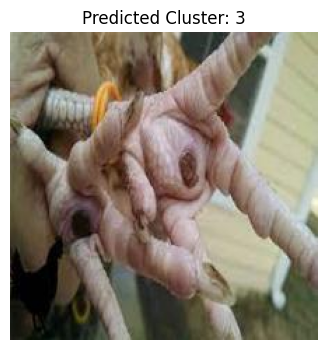

In [12]:
# %% [code] Upload a new image and assign a cluster
print("Please upload an image to test the model.")
uploaded = files.upload()

# Process the first uploaded image
if uploaded:
    for filename in uploaded.keys():
        # Open and preprocess the image: resize and normalize.
        img = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
        img_resized = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 128, 128, 3)

        # Extract feature vector using the trained encoder
        feature_vector = encoder.predict(img_array)

        # Predict the cluster assignment using the trained KMeans model
        cluster_prediction = kmeans.predict(feature_vector)[0]

        # Display the uploaded image and its cluster assignment
        plt.figure(figsize=(4,4))
        plt.imshow(img_resized)
        plt.title(f"Predicted Cluster: {cluster_prediction}")
        plt.axis('off')
        plt.show()
        break  # Process only the first image uploaded
